# 2 基于Python模仿常见抽象地图

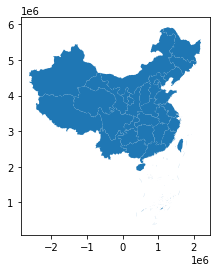

In [1]:
import geopandas as gpd
import requests

# 定义CRS
albers_proj = '+proj=aea +lat_1=25 +lat_2=47 +lon_0=105'

# 从高德接口获取中国地图数据
china = (
    gpd
    .GeoDataFrame
    .from_features(requests
                   .get('https://geo.datav.aliyun.com/areas_v2/bound/100000_full.json')
                   .json(),
                   crs='EPSG:4326'
                  )
    .to_crs(albers_proj)
)

china.plot();

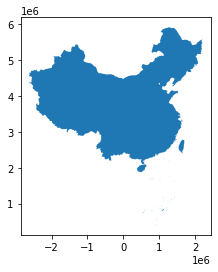

In [2]:
# 得到融合为一个要素的中国地图
china_total = gpd.GeoSeries([china.iloc[:-1, :].unary_union], crs=albers_proj)
china_total.plot();

## 2.1 向外环形扩散的地图

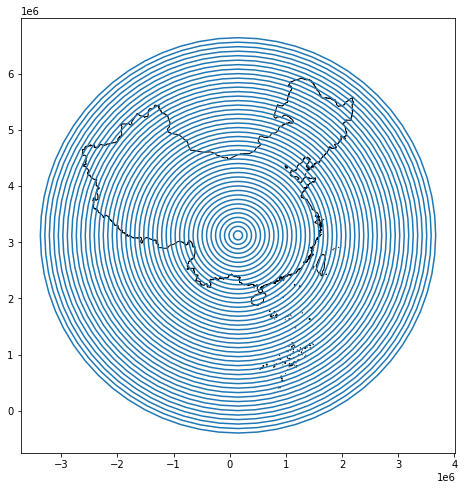

In [3]:
from shapely.geometry import Point
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

# 以重庆为圆心，生成向外的环形线
center = gpd.GeoSeries([Point((106.546737, 29.566598))], crs='EPSG:4326').to_crs(albers_proj)
circles = gpd.GeoSeries([center[0].buffer(i*1000*80).boundary for i in range(1, 45)], crs=albers_proj)

ax = china_total.plot(ax=ax, facecolor='none', edgecolor='black')
ax = circles.plot(ax=ax)

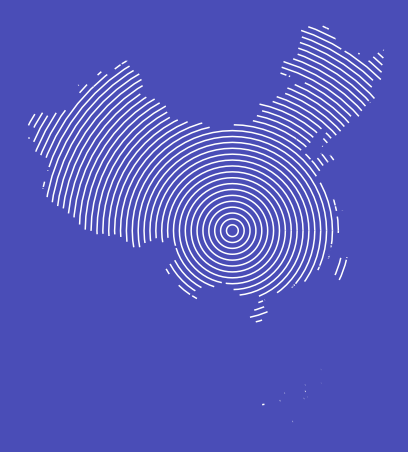

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))

# 用china_total作为蒙版从circles中裁切出绘图所需部分
ax = gpd.clip(circles, mask=china_total).plot(ax=ax, color='white')

ax.set_facecolor('#4a4db7')

fig.set_facecolor('#4a4db7')

ax.set_xticks([])
ax.set_yticks([])

ax.spines['left'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_color('none')

fig.savefig('图5.png', dpi=500, bbox_inches='tight', pad_inches=0)

## 2.2 像素风格的地图

<AxesSubplot:>

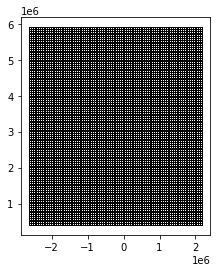

In [5]:
from shapely.geometry import MultiLineString
from shapely.ops import polygonize # 用于将交叉线转换为网格面
import numpy as np

# 提取china_total左下角与右上角坐标
xmin, ymin, xmax, ymax = china_total.total_bounds
xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)

# 创建x方向上的所有坐标位置，间距50公里
x = np.arange(xmin, xmax, 50*1000)

# 创建y方向上的所有坐标位置，间距50公里
y = np.arange(ymin, ymax, 50*1000)

# 生成全部交叉线坐标信息
hlines = [((x1, yi), (x2, yi)) for x1, x2 in zip(x[:-1], x[1:]) for yi in y]
vlines = [((xi, y1), (xi, y2)) for y1, y2 in zip(y[:-1], y[1:]) for xi in x]

grids = gpd.GeoSeries(list(polygonize(MultiLineString(hlines + vlines))), crs=albers_proj)
grids.plot(facecolor='none', edgecolor='black')

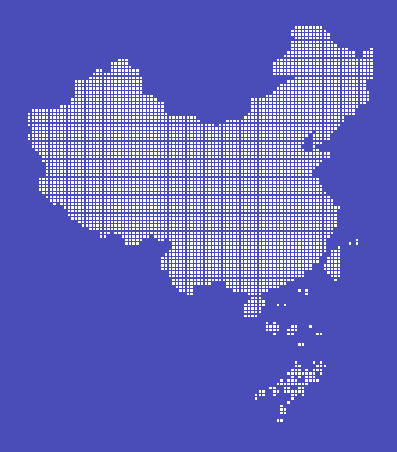

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))

(
    grids[grids.intersects(china_total.geometry[0])]
    .buffer(distance=-8*1000) # 向内缓冲8公里
    .plot(facecolor='white', ax=ax)
)

ax.set_facecolor('#4a4db7')
fig.set_facecolor('#4a4db7')

ax.set_xticks([])
ax.set_yticks([])

ax.spines['left'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_color('none')

fig.savefig('图7.png', dpi=500, bbox_inches='tight', pad_inches=0)

## 2.3 由不规则多边形拼凑的地图

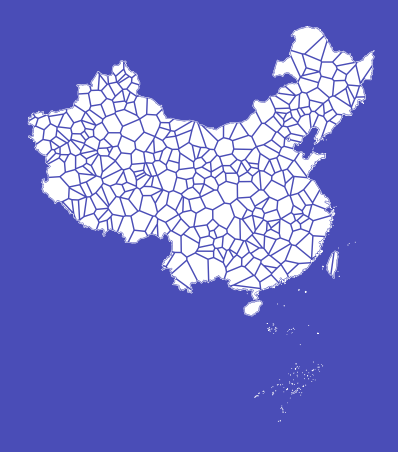

In [7]:
from geovoronoi import voronoi_regions_from_coords


np.random.seed(42)
coords = gpd.GeoSeries([Point(x, y) for x, y in zip(np.random.uniform(xmin, xmax, 1000), 
                                                    np.random.uniform(ymin, ymax, 1000))],
                       crs=albers_proj)

# 得到china_total内部的散点坐标数组
coords = coords[coords.within(china_total[0])]

# 利用geovoronoi得到所需的泰森多边形，其中poly_shapes即为我们需要的多边形
poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(np.array(coords.apply(lambda g: (g.x, g.y)).tolist()), 
                                                                       china_total[0])

fig, ax = plt.subplots(figsize=(8, 8))

ax = china_total.plot(ax=ax, facecolor='none', 
                      edgecolor='white', linewidth=0.5)

(
    gpd
    .GeoSeries(poly_shapes)
    .buffer(-10*1000)
    .plot(ax=ax, 
          facecolor='white',
          linewidth=0.2)
)

ax.set_xticks([])
ax.set_yticks([])

ax.set_facecolor('#4a4db7')
fig.set_facecolor('#4a4db7')

ax.spines['left'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_color('none')

fig.savefig('图8.png', dpi=500, bbox_inches='tight', pad_inches=0)